In [1]:
from lstm_model import build_open_loop_lstm, load_open_loop_lstm
from data_processing import create_training_split, df_training_split, create_df_3d, create_window_closed_loop, add_new_pred, compute_lyapunov_time_arr, train_valid_test_split, df_train_valid_test_split
import warnings
import seaborn as sns
import datetime
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow_datasets as tfds
import plot_file
import importlib
plt.rcParams['figure.facecolor'] = 'w'
warnings.simplefilter(action='ignore', category=FutureWarning)

np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [13]:
%rm -rf ./50_window_100LSTM/Images/LSTM_0_washout/run_1502/logs/fit/250_oloop/

In [43]:
mydf = np.genfromtxt('CSV/lorenz_normalized.csv', delimiter=',')
time = mydf[0, :]
mydf = mydf[1:, :]
df_train, df_valid, df_test = df_train_valid_test_split(mydf)
time_train, time_valid, time_test = train_valid_test_split(time)
x_train, x_valid, x_test = train_valid_test_split(mydf[0, :])
y_train, y_valid, y_test = train_valid_test_split(mydf[1, :])
z_train, z_valid, z_test = train_valid_test_split(mydf[2, :])

In [44]:
window_size = 50
batch_size = 32
shuffle_buffer_size = df_train.shape[0]
train_dataset = create_df_3d(df_train.transpose(
), window_size, batch_size, shuffle_buffer_size)
valid_dataset = create_df_3d(df_valid.transpose(), window_size, batch_size, 1)
test_dataset = create_df_3d(df_test.transpose(), window_size, batch_size, 1)

In [45]:
def custom_loss(y_true, y_pred, washout=0):
    mse = tf.keras.losses.MeanSquaredError()
    # (batchsize, dimensions)
    loss = mse(y_true[washout:, :], y_pred[washout:, :])
    return loss

In [46]:
def build_open_loop_lstm():
    lstm_init = tf.keras.initializers.GlorotUniform(seed=0)
    dense_init = tf.keras.initializers.GlorotUniform(seed=1)
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(8, activation='tanh',
                             name='LSTM_1', kernel_initializer=lstm_init),
        tf.keras.layers.Dense(3, name='Dense_1', kernel_initializer=dense_init)
    ])
    optimizer = tf.keras.optimizers.Adam()
    mse_loss = tf.keras.losses.MeanSquaredError()
    model.compile(loss=custom_loss, optimizer=optimizer, metrics=['mse'])
    return model

In [47]:
def random_int_window_dist(df_transposed, n_int, window_size=50, batch_size=32):
    idx = [batch_size * i for i in sorted(random.sample(range(185), n_int))]
    return idx


def add_cloop_prediction(df_transposed, idx, predictions):
    window_list = np.array(
        [
            np.append(
                df_transposed[idx[i] + 1 : idx[i] + 50, :],
                predictions[i, :].reshape(1, 3),
                axis=0,
            ).reshape(50, 3)
            for i in range(0, len(idx))
        ]
    )
    label_list = np.array([df_transposed[i + 52, :] for i in idx])
    return window_list, label_list

In [48]:
model_oloop.optimizer.lr.assign(new_learning_rate)

NameError: name 'new_learning_rate' is not defined

Epoch 1/100
186/186 [==============================] - 4s 12ms/step - loss: 0.1088 - mse: 0.1088 - val_loss: 0.0297 - val_mse: 0.0297
Epoch 2/100
186/186 [==============================] - 2s 10ms/step - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 3/100
186/186 [==============================] - 2s 10ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 4/100
186/186 [==============================] - 2s 10ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 5/100
186/186 [==============================] - 2s 9ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 6/100
186/186 [==============================] - 2s 10ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 7/100
186/186 [==============================] - 2s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 8/100
186/186 [==============================] - 2s 9ms/s

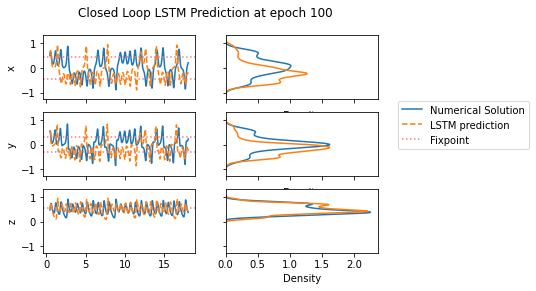

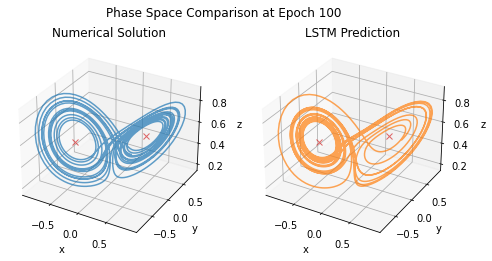

In [49]:
np.random.seed(1234)
tf.random.set_seed(1234)
model_oloop = build_open_loop_lstm()
log_dir = "50_window_100LSTM/Images/LSTM_0_washout/run_1602/logs/fit/" + \
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=10, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

history = model_oloop.fit(train_dataset, epochs=100, batch_size=batch_size,
                          validation_data=valid_dataset, verbose=1, callbacks=[tensorboard_callback])

img_filepath = '50_window_100LSTM/Images/LSTM_10_washout/run_1602/'
if not os.path.exists(img_filepath):
    os.makedirs(img_filepath)
lya_filepath = img_filepath + 'cloop_' + str(history.params['epochs'])+'.png'
predictions = plot_file.plot_closed_loop_lya(
    model_oloop, history.params['epochs'], time_test, df_test, n_length=1950)
phase_filepath = img_filepath + 'phase_cloop_' + str(history.params['epochs'])+'.png'
plot_file.plot_phase_space(
    predictions, history.params['epochs'], df_test)

In [34]:
cloop_size = 32*1
test_window, labels, idx = select_random_batch_with_label(
    df_train.transpose())#, cloop_size)  # np.append(df_train[:, -50:], df_test, axis=1)
predictions = model.predict(np.array(test_window).reshape(cloop_size, 50, 3))

print(predictions.shape)
cloop_windows, cloop_label = add_cloop_prediction(
    df_train.transpose(), idx, predictions)
print(np.array(cloop_windows).shape, cloop_label.shape)


NameError: name 'select_random_batch_with_label' is not defined

Iteration is  0
Epoch 1/100
1/1 - 0s - loss: 3.7009e-05 - mse: 3.8014e-05 - val_loss: 2.9011e-04 - val_mse: 2.8470e-04 - 477ms/epoch - 477ms/step
Epoch 2/100
1/1 - 0s - loss: 9.0897e-06 - mse: 8.7285e-06 - val_loss: 2.9311e-04 - val_mse: 2.9054e-04 - 453ms/epoch - 453ms/step
Epoch 3/100
1/1 - 0s - loss: 2.4194e-06 - mse: 2.5220e-06 - val_loss: 3.0659e-04 - val_mse: 3.0612e-04 - 438ms/epoch - 438ms/step
Epoch 4/100
1/1 - 0s - loss: 2.3340e-05 - mse: 2.2592e-05 - val_loss: 3.0848e-04 - val_mse: 3.0832e-04 - 442ms/epoch - 442ms/step
Epoch 5/100
1/1 - 0s - loss: 2.6303e-05 - mse: 2.6854e-05 - val_loss: 2.9666e-04 - val_mse: 2.9508e-04 - 448ms/epoch - 448ms/step
Epoch 6/100
1/1 - 0s - loss: 9.3791e-06 - mse: 9.0662e-06 - val_loss: 2.8754e-04 - val_mse: 2.8368e-04 - 440ms/epoch - 440ms/step
Epoch 7/100
1/1 - 0s - loss: 5.6297e-07 - mse: 5.4940e-07 - val_loss: 2.8931e-04 - val_mse: 2.8359e-04 - 451ms/epoch - 451ms/step
Epoch 8/100
1/1 - 0s - loss: 1.3221e-05 - mse: 1.2323e-05 - val_loss: 2.91

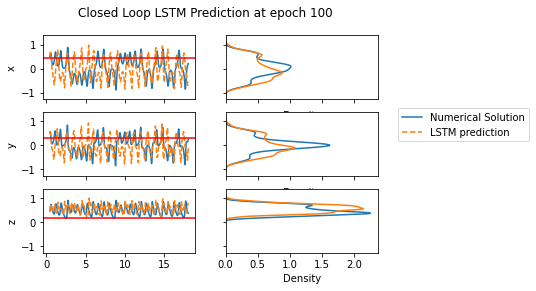

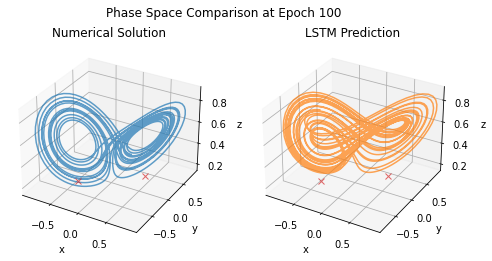

Iteration is  1
Epoch 1/100
1/1 - 0s - loss: 2.6962e-05 - mse: 2.7439e-05 - val_loss: 2.7761e-04 - val_mse: 2.7429e-04 - 462ms/epoch - 462ms/step
Epoch 2/100
1/1 - 0s - loss: 5.2587e-06 - mse: 5.2674e-06 - val_loss: 2.7073e-04 - val_mse: 2.6560e-04 - 437ms/epoch - 437ms/step
Epoch 3/100
1/1 - 0s - loss: 6.7853e-06 - mse: 5.9669e-06 - val_loss: 2.7459e-04 - val_mse: 2.6828e-04 - 486ms/epoch - 486ms/step
Epoch 4/100
1/1 - 0s - loss: 1.8954e-05 - mse: 1.9367e-05 - val_loss: 2.7800e-04 - val_mse: 2.7168e-04 - 449ms/epoch - 449ms/step
Epoch 5/100
1/1 - 0s - loss: 1.3407e-05 - mse: 1.3587e-05 - val_loss: 2.8220e-04 - val_mse: 2.7694e-04 - 436ms/epoch - 436ms/step
Epoch 6/100
1/1 - 0s - loss: 2.5196e-06 - mse: 2.6298e-06 - val_loss: 2.8978e-04 - val_mse: 2.8597e-04 - 439ms/epoch - 439ms/step
Epoch 7/100
1/1 - 0s - loss: 5.3684e-06 - mse: 6.2526e-06 - val_loss: 2.9441e-04 - val_mse: 2.9157e-04 - 443ms/epoch - 443ms/step
Epoch 8/100
1/1 - 0s - loss: 1.2835e-05 - mse: 1.3013e-05 - val_loss: 2.89

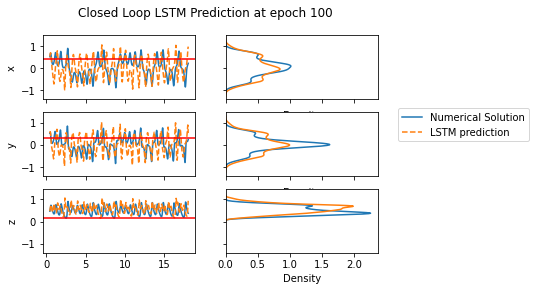

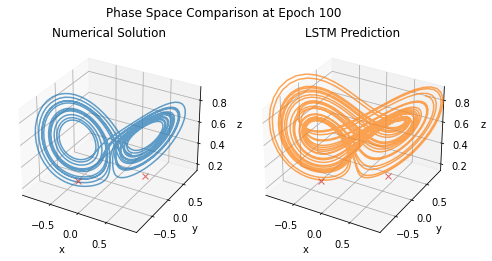

Iteration is  2
Epoch 1/100
1/1 - 0s - loss: 2.5095e-05 - mse: 2.4507e-05 - val_loss: 2.8249e-04 - val_mse: 2.7807e-04 - 465ms/epoch - 465ms/step
Epoch 2/100
1/1 - 0s - loss: 1.9161e-05 - mse: 1.7251e-05 - val_loss: 2.8393e-04 - val_mse: 2.8035e-04 - 433ms/epoch - 433ms/step
Epoch 3/100
1/1 - 0s - loss: 9.9505e-06 - mse: 8.4054e-06 - val_loss: 2.9180e-04 - val_mse: 2.8914e-04 - 443ms/epoch - 443ms/step
Epoch 4/100
1/1 - 0s - loss: 3.1592e-06 - mse: 4.1128e-06 - val_loss: 3.0504e-04 - val_mse: 3.0318e-04 - 440ms/epoch - 440ms/step
Epoch 5/100
1/1 - 0s - loss: 6.3065e-06 - mse: 5.9992e-06 - val_loss: 3.1854e-04 - val_mse: 3.1724e-04 - 437ms/epoch - 437ms/step
Epoch 6/100
1/1 - 0s - loss: 9.5235e-06 - mse: 1.0725e-05 - val_loss: 3.2697e-04 - val_mse: 3.2592e-04 - 441ms/epoch - 441ms/step
Epoch 7/100
1/1 - 0s - loss: 1.4681e-05 - mse: 1.3792e-05 - val_loss: 3.2728e-04 - val_mse: 3.2610e-04 - 436ms/epoch - 436ms/step
Epoch 8/100
1/1 - 0s - loss: 1.2148e-05 - mse: 1.2462e-05 - val_loss: 3.21

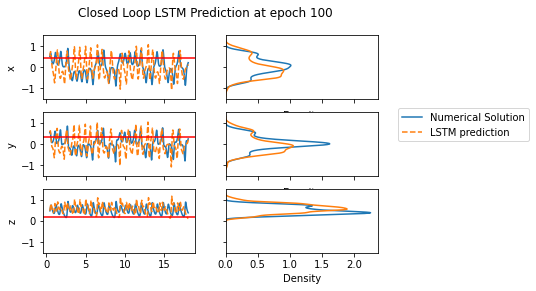

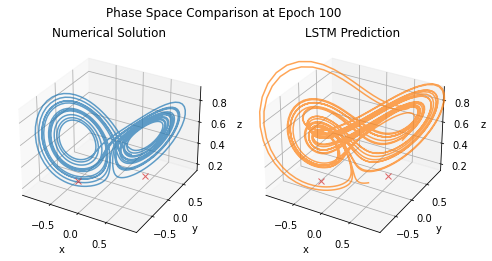

Iteration is  3
Epoch 1/100
1/1 - 0s - loss: 1.9434e-05 - mse: 1.6963e-05 - val_loss: 3.0264e-04 - val_mse: 3.0141e-04 - 467ms/epoch - 467ms/step
Epoch 2/100
1/1 - 0s - loss: 1.2062e-05 - mse: 1.2090e-05 - val_loss: 3.0265e-04 - val_mse: 3.0209e-04 - 439ms/epoch - 439ms/step
Epoch 3/100
1/1 - 0s - loss: 1.1664e-05 - mse: 1.2494e-05 - val_loss: 3.0343e-04 - val_mse: 3.0303e-04 - 448ms/epoch - 448ms/step
Epoch 4/100
1/1 - 0s - loss: 1.4651e-05 - mse: 1.2773e-05 - val_loss: 3.0583e-04 - val_mse: 3.0517e-04 - 439ms/epoch - 439ms/step
Epoch 5/100
1/1 - 0s - loss: 8.1747e-06 - mse: 7.6683e-06 - val_loss: 3.0824e-04 - val_mse: 3.0693e-04 - 442ms/epoch - 442ms/step
Epoch 6/100
1/1 - 0s - loss: 6.4077e-06 - mse: 6.0285e-06 - val_loss: 3.0782e-04 - val_mse: 3.0597e-04 - 443ms/epoch - 443ms/step
Epoch 7/100
1/1 - 0s - loss: 6.1837e-06 - mse: 6.8421e-06 - val_loss: 3.0666e-04 - val_mse: 3.0456e-04 - 440ms/epoch - 440ms/step
Epoch 8/100
1/1 - 0s - loss: 7.2166e-06 - mse: 6.7635e-06 - val_loss: 3.07

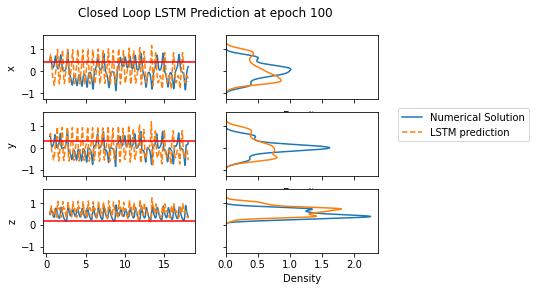

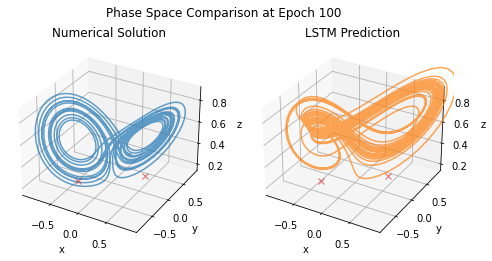

Iteration is  4
Epoch 1/100
1/1 - 0s - loss: 3.9868e-05 - mse: 3.8346e-05 - val_loss: 3.3898e-04 - val_mse: 3.3893e-04 - 463ms/epoch - 463ms/step
Epoch 2/100
1/1 - 0s - loss: 2.2627e-05 - mse: 2.7489e-05 - val_loss: 3.2829e-04 - val_mse: 3.2741e-04 - 439ms/epoch - 439ms/step
Epoch 3/100
1/1 - 0s - loss: 1.3592e-05 - mse: 1.5272e-05 - val_loss: 3.2354e-04 - val_mse: 3.2175e-04 - 434ms/epoch - 434ms/step
Epoch 4/100
1/1 - 0s - loss: 7.6671e-06 - mse: 7.9238e-06 - val_loss: 3.2698e-04 - val_mse: 3.2434e-04 - 441ms/epoch - 441ms/step
Epoch 5/100
1/1 - 0s - loss: 8.4180e-06 - mse: 7.6744e-06 - val_loss: 3.3545e-04 - val_mse: 3.3216e-04 - 437ms/epoch - 437ms/step
Epoch 6/100
1/1 - 0s - loss: 1.2837e-05 - mse: 1.2445e-05 - val_loss: 3.4228e-04 - val_mse: 3.3873e-04 - 443ms/epoch - 443ms/step
Epoch 7/100
1/1 - 0s - loss: 1.5596e-05 - mse: 1.6849e-05 - val_loss: 3.4337e-04 - val_mse: 3.3987e-04 - 439ms/epoch - 439ms/step
Epoch 8/100
1/1 - 0s - loss: 1.9013e-05 - mse: 1.8010e-05 - val_loss: 3.37

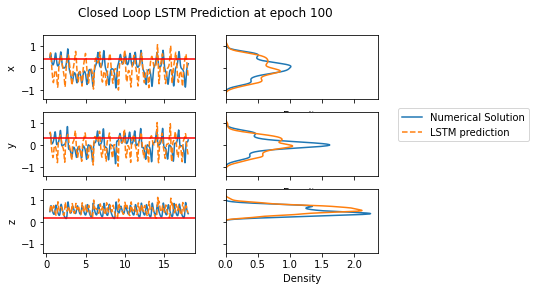

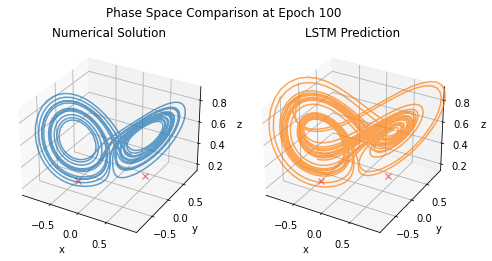

In [ ]:
for i in range(0, 5):
    print('Iteration is ', i)
    cloop_size = 32*1
    test_window, labels, idx = select_random_batch_with_label(
    df_train.transpose())#, cloop_size)  # np.append(df_train[:, -50:], df_test, axis=1)
    predictions = model.predict(np.array(test_window).reshape(cloop_size, 50, 3))
    cloop_windows, cloop_label = add_cloop_prediction(
    df_train.transpose(), idx, predictions)
    history = model.fit(cloop_windows, cloop_label, epochs=100, batch_size=32,
                        validation_data=valid_dataset, callbacks=[tensorboard_callback, early_stop_callback], verbose=2)

    predictions = plot_file.plot_closed_loop_lya(
        model, history.params['epochs'], time_test, df_test, n_length=1950)

    plot_file.plot_phase_space(
        predictions, history.params['epochs'], df_test)

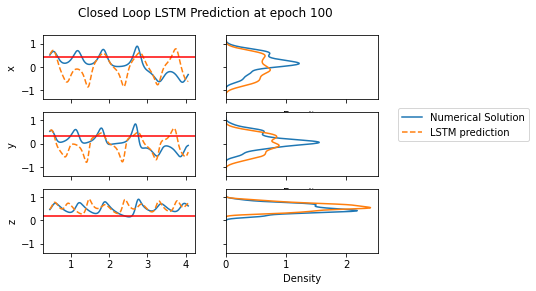

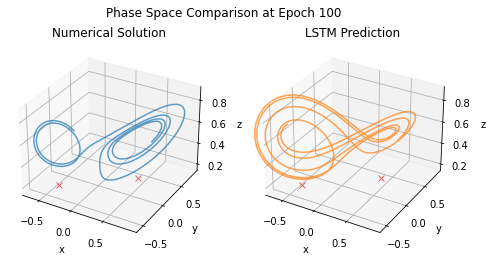

In [ ]:
img_filepath = '100_window_200LSTM/Images/LSTM_10_washout/run_1002/'
lya_filepath = img_filepath + 'cloop_' + str(history.params['epochs'])+'.png'
predictions = plot_file.plot_closed_loop_lya(
    model, history.params['epochs'], time_test, df_test, n_length=400)
phase_filepath = img_filepath + 'phase_cloop_' + \
    str(history.params['epochs'])+'.png'
plot_file.plot_phase_space(
    predictions, history.params['epochs'], df_test)

In [119]:

img_filepath = '50_window_100LSTM/Images/LSTM_10_washout/run_1002/'

if not os.path.exists(img_filepath):
    os.makedirs(img_filepath)

Epoch 1/50
185/185 - 14s - loss: 67.2602 - mse: 67.7159 - val_loss: 21.4492 - val_mse: 22.4350 - 14s/epoch - 77ms/step
Epoch 2/50
185/185 - 13s - loss: 11.6937 - mse: 11.9141 - val_loss: 5.6162 - val_mse: 5.9756 - 13s/epoch - 70ms/step
Epoch 3/50
185/185 - 13s - loss: 3.3971 - mse: 3.5333 - val_loss: 2.9361 - val_mse: 3.2169 - 13s/epoch - 71ms/step
Epoch 4/50
185/185 - 13s - loss: 1.7377 - mse: 1.8399 - val_loss: 1.9088 - val_mse: 2.1444 - 13s/epoch - 71ms/step
Epoch 5/50
185/185 - 13s - loss: 1.1614 - mse: 1.2376 - val_loss: 1.5852 - val_mse: 1.7166 - 13s/epoch - 71ms/step
Epoch 6/50
185/185 - 13s - loss: 0.8484 - mse: 0.9098 - val_loss: 1.4131 - val_mse: 1.5098 - 13s/epoch - 71ms/step
Epoch 7/50
185/185 - 13s - loss: 0.6487 - mse: 0.7017 - val_loss: 1.1899 - val_mse: 1.2539 - 13s/epoch - 71ms/step
Epoch 8/50
185/185 - 13s - loss: 0.4631 - mse: 0.4850 - val_loss: 0.5635 - val_mse: 0.6046 - 13s/epoch - 72ms/step
Epoch 9/50
185/185 - 13s - loss: 0.3618 - mse: 0.3836 - val_loss: 0.5778 -

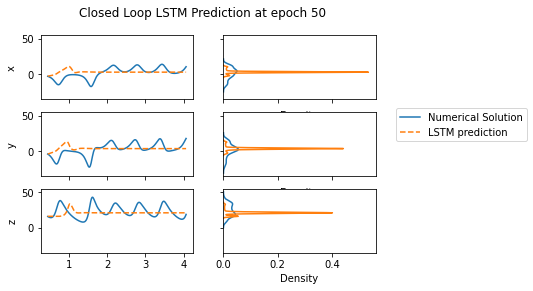

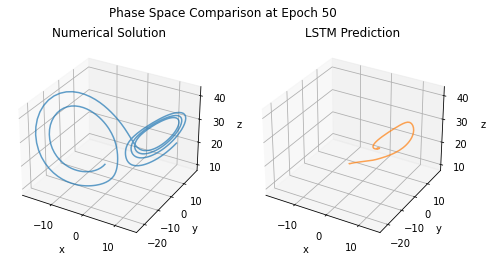

In [107]:
np.random.seed(1234)
tf.random.set_seed(1234)
model_oloop = build_open_loop_lstm()
img_filepath = '100_window_200_LSTM_unnorm/Images/LSTM_10_washout/run_1002/'

n_epochs_old = 0
# Save the weights
for i in range(0, 1):
    n_epochs = n_epochs_old + 50
    history = model_oloop.fit(train_dataset, epochs=n_epochs, initial_epoch=n_epochs_old, batch_size=batch_size,
                              validation_data=valid_dataset, verbose=2)  # , callbacks=[tensorboard_callback]) #, early_stop_callback])
    n_epochs_old = n_epochs
    lya_filepath = img_filepath + 'cloop_' + str(n_epochs)+'.png'
    predictions = plot_file.plot_closed_loop_lya(
        model_oloop, n_epochs, time_test, df_test, lya_filepath, n_length=400)
    phase_filepath = img_filepath + 'phase_cloop_' + str(n_epochs)+'.png'
    plot_file.plot_phase_space(predictions, n_epochs, df_test, phase_filepath)

In [113]:
predictions

array([[-2.6030207, -3.9792826, 16.203121 ],
       [-2.5174987, -3.980492 , 16.152874 ],
       [-2.4285817, -3.8572104, 16.191435 ],
       ...,
       [ 3.0713782,  3.4738128, 21.115208 ],
       [ 3.071379 ,  3.4738133, 21.115208 ],
       [ 3.0713801,  3.4738128, 21.115208 ]], dtype=float32)

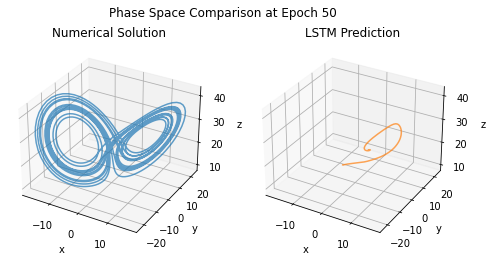

In [110]:
plot_file.plot_phase_space(predictions, n_epochs, df_test, phase_filepath)

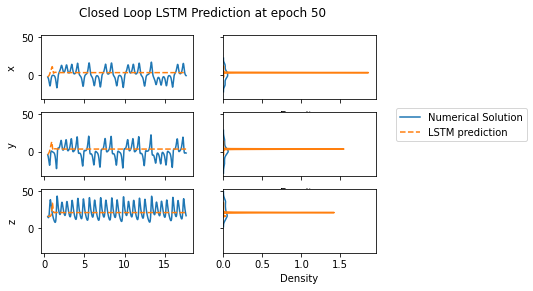

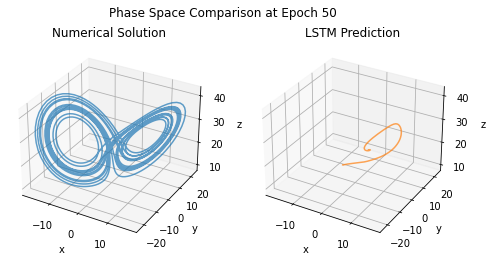

In [109]:
predictions = plot_file.plot_closed_loop_lya(
    model_oloop, n_epochs, time_test, df_test, lya_filepath, n_length=1900)
phase_filepath = img_filepath + 'phase_cloop_' + str(n_epochs)+'.png'
plot_file.plot_phase_space(predictions, n_epochs, df_test, phase_filepath)

In [172]:
model = model_oloop
forecast = model.predict(test_dataset)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


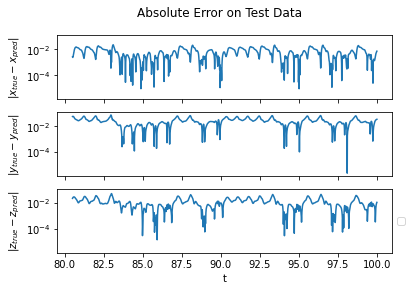

In [173]:
err = df_test.transpose()[50:, :] - forecast
abs_error = np.abs(df_test.transpose()[50:, :] - forecast)

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True,
                                    sharey=True, facecolor='w')  # , figsize=(15, 15))
fig.suptitle('Absolute Error on Test Data')
ax1.plot(time_test[50:], abs_error[:, 0])
ax1.set_ylabel(r'$|x_{true}-x_{pred}|$')
ax1.set_yscale('log')
ax2.plot(time_test[50:], abs_error[:, 1])
ax2.set_ylabel(r'$|y_{true}-y_{pred}|$')
ax2.set_yscale('log')
ax3.plot(time_test[50:], abs_error[:, 2])
ax3.set_ylabel(r'$|z_{true}-z_{pred}|$')
ax3.set_xlabel('t')
ax3.set_yscale('log')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#fig.savefig(error_filepath, dpi=1000, facecolor="w")

In [183]:
model_checkpoint = 'oloop_lstm_Washout_0/250_epoch_cp'
# Save the weights
model_oloop.save_weights(model_checkpoint)

In [28]:
def select_random_window_with_label(df_transposed, n_windows, window_size=50, n_dim=3):
    idx = random.sample(range(len(df_transposed)-window_size-1), n_windows)
    window_list = np.array([df_transposed[i:i+window_size, :].reshape(window_size, 3)
                           for i in idx])  # .reshape((n_windows,window_size,n_dim))
    label_list = np.array([df_transposed[i+window_size+1, :].reshape(n_dim)
                          for i in idx])  # .reshape(n_windows, n_dim)
    return window_list, label_list, idx


def add_cloop_prediction(df_transposed, idx, predictions):
    window_list = np.array([np.append(df_train.transpose()[idx[i]+1:idx[i]+50, :],
                           predictions[i, :].reshape(1, 3), axis=0).reshape(50, 3) for i in range(0, len(idx))])
    label_list = np.array([df_transposed[i+52, :] for i in idx])
    return window_list, label_list

In [56]:
def select_random_batch_with_label(df_transposed):
    idx_start = random.randint(0, len(df_transposed) - 50 - 1)
    idx = np.arange(start=idx_start, stop=idx_start + 32)
    # window_list =[]
    window_list = [df_transposed[i : i + 50, :].reshape(1, 50, 3) for i in idx]
    label_list = [df_transposed[i + 51, :].reshape(1, 3) for i in idx]
    return window_list, label_list, idx

In [66]:
def random_int_window_dist(df_transposed, n_int, window_size=50, batch_size=32):
    """returns a list of random ints of length n_int which all have distance n_window"""
    idx = [
        (50+batch_size) * i + x
        for i, x in enumerate(
            sorted(random.sample(range(len(df_transposed) - window_size - batch_size - 1), n_int))
        )
    ]
    return idx

In [87]:
def select_random_batches_with_label(df_transposed, n_int, window_size=50, batch_size=32):
    idx = random_int_window_dist(df_transposed, n_int, window_size=window_size)
    idx_list = np.array([np.arange(start=idx_start, stop=idx_start + 32) for idx_start in idx]).flatten()
    window_list = [df_transposed[i : i + 50, :].reshape(1, 50, 3) for i in idx_list]
    label_list = [df_transposed[i + 51, :].reshape(1, 3) for i in idx_list]
    return np.array(window_list), np.array(label_list), idx_list

In [85]:
model_oloop.fit(window_list.reshape(64, 50, 3), label_list, epochs=2, batch_size=32,
                        validation_data=valid_dataset, callbacks=[tensorboard_callback, early_stop_callback], verbose=2)


Epoch 1/2
2/2 - 1s - loss: 0.0823 - mse: 0.0823 - val_loss: 4.4277e-04 - val_mse: 4.4277e-04 - 1s/epoch - 540ms/step
Epoch 2/2
2/2 - 0s - loss: 0.0747 - mse: 0.0747 - val_loss: 0.0019 - val_mse: 0.0019 - 484ms/epoch - 242ms/step


2022-02-04 13:53:51.822009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-04 13:53:51.870392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


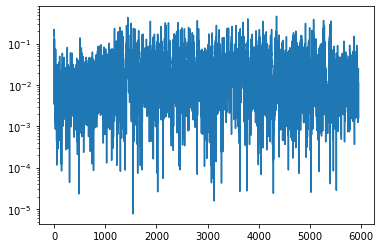

In [26]:
forecast = model.predict(train_dataset)
forecast_err = np.abs(df_train.transpose()[50:, :] - forecast)
plt.plot(forecast_err[:, 0])
plt.yscale('log')

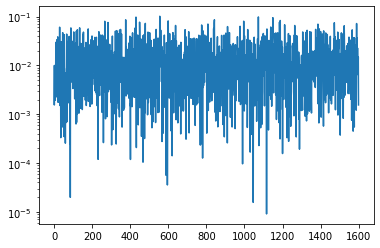

In [27]:
error = np.abs(labels - predictions)
plt.plot(error[:, 1])
plt.yscale('log')

In [26]:
[50*i + x for i, x in enumerate(sorted(random.sample(range(1000), 10)))]

[190, 246, 319, 403, 473, 560, 888, 1054, 1112, 1374]

In [24]:
[50*i + x for i, x in enumerate(sorted(random.sample(range(5), 5)))]

[0, 51, 102, 153, 204]